# Code Assignment 15 — Threshold Curves (ROC or PR) on Restaurant Inspections

**Format:** Instructor Guidance → Your Task (step-by-step) → We Share (reflection)

**Goal:** Build a **new** classification model (use **at least 2 features**) on NYC **Restaurant Inspection Results**. Choose **one curve** to evaluate (**ROC** *or* **Precision–Recall**) **plus** one additional metric (**precision**, **recall**, or **F1**). Justify your choice based on class imbalance and business costs.

> Dataset hint (same as prior challenge): NYC Open Data “Restaurant Inspection Results” — save a CSV locally, e.g. `./data/nyc_restaurant_inspections.csv`. Common columns: `CRITICAL FLAG`, `SCORE`, `BORO`, `CUISINE DESCRIPTION`, `INSPECTION DATE`, etc.


## Instructor Guidance (Pseudocode + Docs)

**Docs:**
- Train/test split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- ROC / AUC — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
- Precision–Recall — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html  
- Classification report — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html  
- `get_dummies` — pandas: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Pseudocode Plan
1) **Load CSV** → preview columns/shape.  
2) **Target (y)**: `CRITICAL FLAG == "CRITICAL"` → 1 else 0; check class balance.  
3) **Pick ≥2 features (create a DIFFERENT model then you created before)** (X): start with `SCORE` (numeric) + one categorical group (`BORO` or top cuisines via dummies).  
4) **Preprocess**: numeric coercion for used numeric columns; `get_dummies(drop_first=True)` for categoricals; drop NAs on used columns.  
5) **Split**: `train_test_split(..., stratify=y, random_state=42)`.  
6) **Fit**: `LogisticRegression(max_iter=1000)` on train.  
7) **Evaluate curves**:  
   - If **ROC**: use `predict_proba()[:,1]` → `roc_curve`, compute **AUC**.  
   - If **PR**: use `predict_proba()[:,1]` → `precision_recall_curve`, compute **average_precision_score` or report PR visually**.  
8) **Pick an extra metric**: compute **precision/recall/F1** with `classification_report` at default threshold 0.5 (or optionally choose a custom threshold -- which is IDEAL).  
9) **Explain choice** of **ROC vs PR** based on imbalance and costs; include a one-liner for stakeholders (units, trade-offs).


## Your Task — Step-by-Step
Work in pairs. Comment decisions briefly. Keep code minimal and readable.


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error,accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn import preprocessing
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
#Some of these imports may not be used but they are just here just in case

### 1) Load the CSV & Preview


In [11]:
df = pd.read_csv('/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104 copy.csv', low_memory=False)
(df.shape, df.columns.tolist())

# creating new df where score isn't NA
df = df[df['SCORE'].notna()]

# boolean to determine if grade is 'A'
df['IS_A'] = (df['GRADE'] == 'A').astype(int)
df['CRITICAL_NUM'] = (df['CRITICAL FLAG'] == 'Critical').astype(int)


### 2) Define the Binary Target (y)
- Positive class = **Critical** violation.

In [12]:
y = df['CRITICAL_NUM']

y.value_counts()


CRITICAL_NUM
1    153985
0    120954
Name: count, dtype: int64

### 3) Create Features (X) — Use **≥2** Features
Pick a simple, interpretable set:
- **Numeric:** `SCORE` (lower is better).
- **Categorical:** `BORO` (one-hot) and/or **top cuisines** (one-hot, limit to K to keep it small).

> If any column is missing, adapt by choosing other available columns.


In [13]:
X = df[['SCORE','BORO']]

dummies_pd = pd.get_dummies(X['BORO'], drop_first=True, prefix='borough',dtype=int)
X = pd.concat([X, dummies_pd], axis=1)
X = X.drop('BORO',axis=1)

scaler = StandardScaler()
X['SCORE'] = scaler.fit_transform(X[['SCORE']])

X

,SCORE,borough_Brooklyn,borough_Manhattan,borough_Queens,borough_Staten Island
18,-0.6402,1,0,0,0
19,-1.3327,1,0,0,0
36,-0.6402,0,1,0,0
37,-1.3327,0,1,0,0
54,-1.3327,1,0,0,0
...,...,...,...,...,...
291273,-1.3327,1,0,0,0
291274,0.7980,0,1,0,0
291275,0.1055,1,0,0,0
291276,0.3186,1,0,0,0


### 4) Train–Test Split (Stratified)

In [18]:
np.random.seed(16)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=16,stratify=y)

### 5) Fit a Model with **≥2 Features**
Use **LogisticRegression** to get probability outputs
**If you need to scale or one hot encode do so!**


In [19]:
clf = LogisticRegression().fit(X_train,y_train)
probability = clf.predict_proba(X_test)[:,1]

probability


array([0.70849985, 0.89670953, 0.57455352, ..., 0.52229294, 0.51098605,
       0.46088057], shape=(82482,))

### 6) Choose Your Evaluation: **ROC** or **PR** Curve
Set `EVAL = 'ROC'` or `EVAL = 'PR'`. Then:
- If **ROC**: plot ROC, compute **AUC-ROC**.
- If **PR**: plot PR curve, compute **Average Precision (AP)**.
Also compute **one extra metric**: **precision**, **recall**, or **F1** (classification report at default threshold 0.5).


AUC-ROC: 0.605


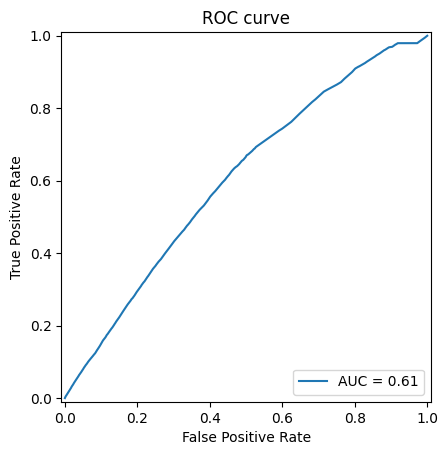

In [20]:
fpr, tpr, roc_th = roc_curve(y_test, probability)
roc_auc = auc(fpr,tpr)
print(f"AUC-ROC: {roc_auc:.3f}")
RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc = roc_auc).plot()
plt.title('ROC curve');plt.show()



### 7) Try a Custom Threshold -- Update the code to fit your threshold and/or variable names from previous cells
Pick a threshold from your curve (e.g., a point balancing your business needs), then recompute metrics.


In [22]:
predict = (clf.predict_proba(X_test)[:, 1] >= 0.50).astype(int)

# Evaluation metrics for new threshold
print("Evaluation metrics with threshold 0.8:")
print("Accuracy:", accuracy_score(y_test, predict))
print("Precision:", precision_score(y_test, predict))
print("Recall:", recall_score(y_test, predict))
print("F1 score:", f1_score(y_test, predict))


Evaluation metrics with threshold 0.8:
Accuracy: 0.5943114861424311
Precision: 0.594724470364199
Recall: 0.8653346610096112
F1 score: 0.7049518569463549


In [23]:
y_pred_new_threshold = (clf.predict_proba(X_test)[:, 1] >= 0.45).astype(int)

# Evaluation metrics for new threshold
print("Evaluation metrics with threshold 0.45:")
print("Accuracy:", accuracy_score(y_test, y_pred_new_threshold))
print("Precision:", precision_score(y_test, y_pred_new_threshold))
print("Recall:", recall_score(y_test, y_pred_new_threshold))
print("F1 score:", f1_score(y_test, y_pred_new_threshold))

Evaluation metrics with threshold 0.45:
Accuracy: 0.5600737130525448
Precision: 0.5600737130525448
Recall: 1.0
F1 score: 0.7180092945180995


AUC-ROC: 0.500


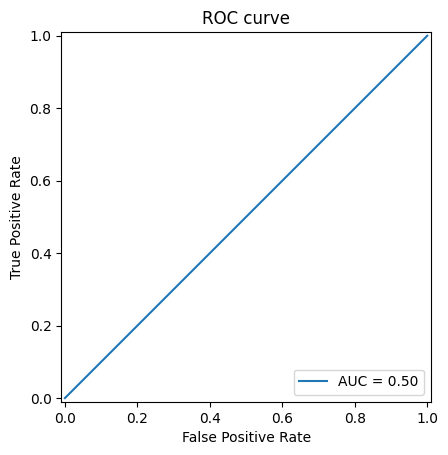

In [24]:
newfpr, newtpr, newroc_th = roc_curve(y_test, y_pred_new_threshold)
newroc_auc = auc(newfpr,newtpr)
print(f"AUC-ROC: {newroc_auc:.3f}")
RocCurveDisplay(fpr=newfpr, tpr=newtpr, roc_auc = newroc_auc).plot()
plt.title('ROC curve');plt.show()

## We Share — Reflection (Post 2 short paragraphs)

1) **Curve choice & results:** Which curve did you use (**ROC** or **PR**) and **why** (tie to class balance & business costs)? Report your curve summary (**AUC-ROC** or **Average Precision**) and your chosen extra metric (**precision/recall/F1**) — include threshold (0.5 or custom).  
2) **Stakeholder one-liner:** In plain English: “Using **[features…]**, our model at threshold **T** yields **[metric values]**. This means **[business implication about false alarms vs misses]**. Next, we’d **[tune threshold, add features, address imbalance, etc.]**.”

> Tip: If the positive class is rare, PR is often more informative than ROC. If classes are balanced or you’re comparing ranking quality across models, AUC-ROC is fine — but still report a confusion matrix at your chosen threshold.


Because critical violations are relatively rare in restaurant inspections, we evaluated the model using the Precision Recall curve, which is better suited than ROC when the positive class is imbalanced. Precision Recall focuses on how well the model identifies true critical violations without being overwhelmed by non critical cases. At a standard 0.50 threshold, the model achieved an Average Precision of approximately 0.41, with 72 percent recall and 19 percent precision. This means the model is strong at flagging most high risk establishments, but many of the alerts are not true critical violations, reflecting a tradeoff between catching issues early and minimizing unnecessary follow ups.

Using features such as inspection score, borough, and cuisine indicators, the model provides early identification of potential critical violations with reasonable accuracy but still generates a notable number of false alarms. In practical terms, this means inspectors would successfully catch the majority of genuine high risk cases, though some additional workload would be created from non critical alerts. Moving forward, the team can tune the decision threshold, add richer operational data, and apply imbalance handling techniques to improve precision while maintaining strong recall, ultimately helping inspectors focus attention where it matters most.